# Transferencia de estilo

Basado en el paper: [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

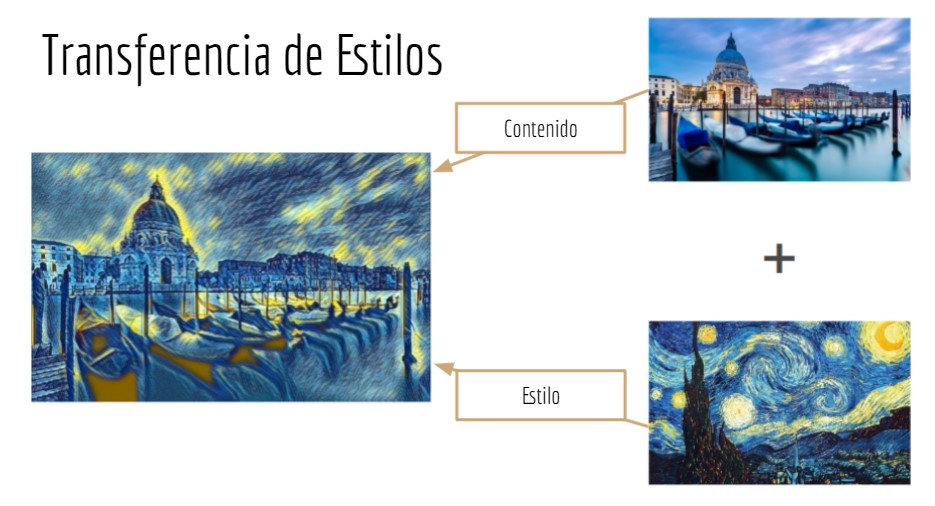






In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


#Se utiliza un modelo pre-entrenado (VGG19)
model = models.vgg19(pretrained=True).features


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


El objetivo es tomar información de las convoluciones posteriores a los MaxPool2d

In [4]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Modificamos la red para

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    #Tomo las features de las capas indicadas
    self.chosen_features = ['0', '5', '10', '19', '28']
    #Tomo hasta el nivel 29, el resto se descarta
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    features = []
    #Guardo las features en listas
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
    
      if str(layer_num) in self.chosen_features:
        features.append(x)
    
    return features
    
def load_image(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device)

#Usar GPU si esta disponible
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

image_size = 600
loader = transforms.Compose(
      [
          transforms.Resize((image_size, image_size)),
          transforms.ToTensor()
      ]
)

original_img = load_image("facundo.jpg") #Imagen de contenido
style_img = load_image("noche_estrellada.jpg") #Imagen de estilo

model = VGG().to(device).eval()

'''
En transferencia de estilo el parametro a entrenar es la imagen de salida.
El objetivo es obtener la imagen que minimize la perdida de contenido y la
perdida de estilo.

Si bien en el paper si empieza con una imagen con ruido, en esta ocasion
vemos que empezar con una copia de la imagen de contenido da resultados
mas rápidos.
'''
generated = original_img.clone().requires_grad_(True) 

# Hiperparametros
total_steps = 18000
learning_rate = 0.001


alpha = 1   #Constante que multiplica la perdida de contenido
beta = 0.01 #Constante que multiplica la perdida de estilo

#Optimizador
optimizer = optim.Adam([generated], lr=learning_rate)

#Entrenamiento
for step in range(total_steps):
  generated_features = model(generated)
  original_img_features = model(original_img)
  style_features = model(style_img)
  
  style_loss = original_loss = 0

  for gen_feature, orig_feature, style_feature in zip(generated_features, original_img_features, style_features):
    
    batch_size, channel, height, width = gen_feature.shape
    original_loss += torch.mean((gen_feature - orig_feature) ** 2)
    
    # Matriz de Gram
    G = gen_feature.view(channel, height*width).mm(
        gen_feature.view(channel, height*width).t()
    )

    A = style_feature.view(channel, height*width).mm(
        style_feature.view(channel, height*width).t()
    )

    style_loss += torch.mean((G - A)**2)

  total_loss = alpha*original_loss + beta * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  if step % 200 == 0:
    print(total_loss)
    name = "/content/gdrive/MyDrive/DeepLearning/" + "generate" + str(step) + ".png"
    save_image(generated, name)
